# Import dataset

In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("michiard/dcase-aml")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/


In [ ]:
import os
import pandas as pd

print(os.listdir('/kaggle/input'))
# → ['dcase-aml-dev-data', …]


notebook_executed_in="kaggle" # or colab

if notebook_executed_in == "kaggle":
    train_dir = '/kaggle/input/dev_data/dev_data/slider/train'
elif notebook_executed_in == "colab":
    train_dir = 'dcase-aml/dev_data/_dev_data/slider/train'  # TODO: verify path in Colab
else:
    raise ValueError(f"Unsupported notebook: {notebook_executed_in}")


# List all files in the train directory
file_names = os.listdir(train_dir)

# Optional: filter to include only certain file types (e.g., .wav, .csv, etc.)
# file_names = [f for f in file_names if f.endswith('.wav')]

# Create a DataFrame
df = pd.DataFrame(file_names, columns=['filename'])

# Display the DataFrame
df.head()

['sample_submission.csv', 'eval_data', 'dev_data']


,filename
0,normal_id_02_00000546.wav
1,normal_id_02_00000764.wav
2,normal_id_00_00000530.wav
3,normal_id_02_00000820.wav
4,normal_id_02_00000102.wav


## Preprocessing : build melspectrograms from audio files

- Input : audio files in data/data
- Output : melspectrograms of size

In [7]:
%matplotlib inline
import librosa
import librosa.display
import IPython.display as ipd
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
from tqdm import tqdm

## Choose the paths

In [8]:
# Enter the path to audio data
PATH_DATASET = "/kaggle/working/"
# Enter the path where spectrograms will be saved
PATH_FEATURES = PATH_DATASET+'Features/'
PATH_MELSPEC = PATH_FEATURES + 'melspec_313_128/'

## Function to build the dataframe of file names with their features for each machine type

In [ ]:
# 1. Ottiene i file e assegna un'etichetta "split" (train/test)
def get_df_files(machine_str):
    path_train_folder = '/kaggle/input/dev_data/dev_data/slider/train'
    path_test_folder = '/kaggle/input/dev_data/dev_data/slider/test'

    train_files = [f for f in os.listdir(path_train_folder) if f.endswith(".wav")]
    test_files = [f for f in os.listdir(path_test_folder) if f.endswith(".wav")]

    list_dict_file = []

    for filename in train_files:
        splitted = filename.replace('.wav', '').split('_')
        list_dict_file.append({
            'filepath': os.path.join(path_train_folder, filename),
            'filename': filename,
            'status': splitted[0],
            'machine_id': f"{splitted[1]}_{splitted[2]}",
            'file_index': splitted[3],
            'split': 'train'
        })

    for filename in test_files:
        splitted = filename.replace('.wav', '').split('_')
        list_dict_file.append({
            'filepath': os.path.join(path_test_folder, filename),
            'filename': filename,
            'status': splitted[0],
            'machine_id': f"{splitted[1]}_{splitted[2]}",
            'file_index': splitted[3],
            'split': 'test'
        })

    return pd.DataFrame(list_dict_file)

## Functions to compute and save the spectograms

In [ ]:
def build_melspectrogram(audio_name, spectro_params):
    #Get audio array
    audio_array, sr = librosa.load(audio_name, sr=None)

    #Get mel spectogram
    melspectrogram = librosa.feature.melspectrogram(
        y = audio_array,
        n_fft = spectro_params['n_fft'],
        hop_length = spectro_params['hop_length'],
        n_mels = spectro_params['n_mels']
    )
    # Express in decibel units
    melspectrogram = librosa.power_to_db(melspectrogram, ref=1e-12)   #  ref=np.max
    # Flatten the spectrogram
    #print("Initial Spectro shape = ", melspectrogram.shape)
    melspectrogram = melspectrogram.reshape(1, -1)
    #print("Final Spectro shape = ", melspectrogram.shape)

    return melspectrogram

# 2. Estrae e salva i mel-spettrogrammi separando train/test
def compute_and_save_spectros(machine_str, spectro_params):
    # Crea directory di base
    os.makedirs(PATH_FEATURES, exist_ok=True)
    os.makedirs(PATH_MELSPEC, exist_ok=True)

    # Directory train/test
    path_train_folder = os.path.join(PATH_MELSPEC, machine_str, 'train')
    path_test_folder = os.path.join(PATH_MELSPEC, machine_str, 'test')
    os.makedirs(path_train_folder, exist_ok=True)
    os.makedirs(path_test_folder, exist_ok=True)

    # Ottiene tutti i file
    df = get_df_files(machine_str)

    for _, row in df.iterrows():
        audio_path = row['filepath']
        melspectrogram = build_melspectrogram(audio_path, spectro_params)

        # Scegli percorso di salvataggio
        subfolder = path_train_folder if row['split'] == 'train' else path_test_folder
        filename = os.path.join(subfolder, row['filename'].replace('.wav', ''))

        np.save(filename, melspectrogram)

## Run it for all machine types

In [11]:
spectro_params = dict(
    n_fft = 1024,     # length of the FFT window
    hop_length = 512,    # number of samples between successive frames
    n_mels = 128       # number of Mel bands to generate
)

machines_list = ['slider']

for machine in tqdm(machines_list):
    compute_and_save_spectros(machine, spectro_params)

100%|██████████| 1/1 [01:27<00:00, 87.91s/it]


### Test

In [ ]:
audio_name = '/kaggle/input/dev_data/dev_data/slider/train/normal_id_00_00000000.wav'

spectro_params = dict(
    n_fft = 1024,
    hop_length = 512,
    n_mels=128
)

spectro = build_melspectrogram(audio_name, spectro_params)

## Plot one spectrogram for test

In [13]:
def plot_spectro(filepath):
    # Load the original melspectogram array
    spectro_array = np.load(filepath).reshape(128, 313)
    # Plot the spectrogram
    librosa.display.specshow(spectro_array, sr = 16000, x_axis = 'time', y_axis = 'mel', cmap = 'magma')

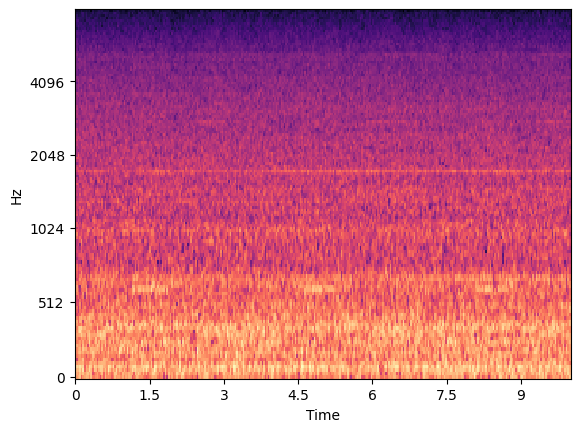

In [14]:
path = '/kaggle/working/Features/melspec_313_128/slider/train/normal_id_00_00000010.npy'
plot_spectro(path)

## Normalization

In [15]:
import os
import numpy as np

def load_all_spectrograms(folder):
    data = []
    for file in os.listdir(folder):
        if file.endswith(".npy") and "normal" in file:
            array = np.load(os.path.join(folder, file)).reshape(-1)  # Flatten per rete fully-connected
            data.append(array)
    return np.array(data)

# Sostituisci con il tuo percorso corretto
folder_path = "/kaggle/working/Features/melspec_313_128/slider/train"
X_train = load_all_spectrograms(folder_path)

print("Shape del dataset:", X_train.shape)

Shape del dataset: (2370, 40064)


In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

## Loading test set

In [17]:
import torch
def load_test_dataset(test_dir):
    X = []
    y = []
    filenames = []

    for fname in sorted(os.listdir(test_dir)):
        if fname.endswith(".npy"):
            fpath = os.path.join(test_dir, fname)
            x = np.load(fpath)

            # Reshape se serve
            if x.ndim == 1:
                x = x.reshape(1, -1)
            elif x.ndim == 2:
                x = x[np.newaxis, ...]

            X.append(x)
            filenames.append(fname)

            # Label dal nome file
            label = 0 if "normal" in fname.lower() else 1
            y.append(label)

    X = np.concatenate(X, axis=0)
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.long)
    return X_tensor, y_tensor, filenames
test_dir = "/kaggle/working/Features/melspec_313_128/slider/test"
X_test, y_test, filenames = load_test_dataset(test_dir)
X_test = X_test.reshape(X_test.shape[0], -1)  # Da (N, 1, 128, 313) a (N, 40192)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test)

## Training Autoencoder

In [33]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Architettura Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 64)
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim)
        )
    def forward(self, x):
        return self.decoder(self.encoder(x))

# Dati e dataloader
tensor_data = torch.tensor(X_train_scaled, dtype=torch.float32)
dataset = TensorDataset(tensor_data)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Istanza modello
input_dim = X_train_scaled.shape[1]
model = Autoencoder(input_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
for epoch in range(30):
    total_loss = 0
    for batch in dataloader:
        x = batch[0]
        output = model(x)
        loss = criterion(output, x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(dataloader):.4f}")

Epoch 1, Loss: 1.0611
Epoch 2, Loss: 0.7747
Epoch 3, Loss: 0.6998
Epoch 4, Loss: 0.6570
Epoch 5, Loss: 0.6111
Epoch 6, Loss: 0.5874
Epoch 7, Loss: 0.5675
Epoch 8, Loss: 0.5703
Epoch 9, Loss: 0.5567
Epoch 10, Loss: 0.5593
Epoch 11, Loss: 0.5387
Epoch 12, Loss: 0.5337
Epoch 13, Loss: 0.5228
Epoch 14, Loss: 0.5119
Epoch 15, Loss: 0.5054
Epoch 16, Loss: 0.5062
Epoch 17, Loss: 0.4959
Epoch 18, Loss: 0.4908
Epoch 19, Loss: 0.4889
Epoch 20, Loss: 0.4850
Epoch 21, Loss: 0.4891
Epoch 22, Loss: 0.4879
Epoch 23, Loss: 0.4782
Epoch 24, Loss: 0.4838
Epoch 25, Loss: 0.4781
Epoch 26, Loss: 0.4799
Epoch 27, Loss: 0.4761
Epoch 28, Loss: 0.4698
Epoch 29, Loss: 0.4690
Epoch 30, Loss: 0.4762


## Anomaly Score Calculation

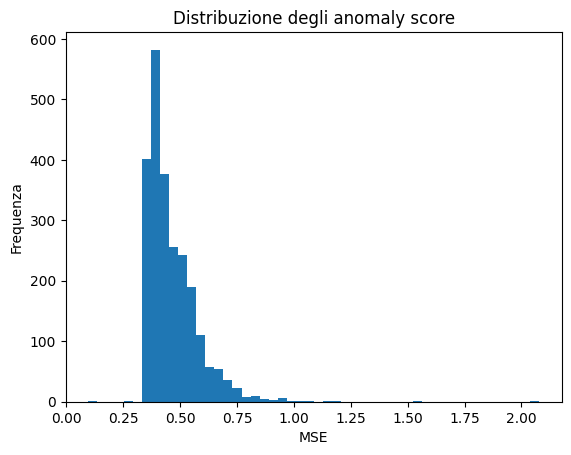

In [34]:
def anomaly_score(model, data):
    model.eval()
    with torch.no_grad():
        inputs = torch.tensor(data, dtype=torch.float32)
        outputs = model(inputs)
        mse = torch.mean((outputs - inputs)**2, dim=1)
    return mse.numpy()

scores = anomaly_score(model, X_train_scaled)

# Visualizza distribuzione dei punteggi
import matplotlib.pyplot as plt
plt.hist(scores, bins=50)
plt.title("Distribuzione degli anomaly score")
plt.xlabel("MSE")
plt.ylabel("Frequenza")
plt.show()

✅ ROC AUC: 0.7109


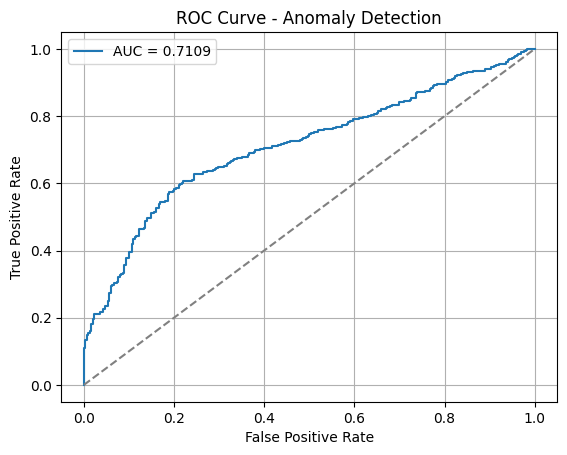

In [35]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
# 🔍 3. Inferenza con autoencoder
model.eval()
with torch.no_grad():
    recon = model(X_test)

# 💥 4. Anomaly score = Mean Squared Error per esempio
reconstruction_errors = torch.mean((X_test - recon) ** 2, dim=tuple(range(1, X_test.ndim))).cpu().numpy()

# 🧠 5. Calcolo AUC ROC
auc_score = roc_auc_score(y_test.numpy(), reconstruction_errors)
print(f"✅ ROC AUC: {auc_score:.4f}")

# 📈 6. (Opzionale) Plotta curva ROC
fpr, tpr, _ = roc_curve(y_test.numpy(), reconstruction_errors)
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Anomaly Detection")
plt.legend()
plt.grid(True)
plt.show()

## VAE Definition

In [55]:
import torch
import torch.nn as nn

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=16):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU()
        )
        self.mu_layer = nn.Linear(256, latent_dim)
        self.logvar_layer = nn.Linear(256, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim)
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)
        mu = self.mu_layer(h)
        logvar = self.logvar_layer(h)
        z = self.reparameterize(mu, logvar)
        recon = self.decoder(z)
        return recon, mu, logvar


### Loss

In [56]:
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.MSELoss()(recon_x, x)
    kl_div = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div


## Training VAE

In [67]:
import torch
import torch.nn as nn

def vae_loss(recon_x, x, mu, logvar, beta=0.001):
    # Ricostruzione (MSE)
    recon_loss = nn.MSELoss()(recon_x, x)
    # KL Divergence
    kl_div = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    # Loss totale pesata
    total_loss = recon_loss + beta * kl_div
    return total_loss, recon_loss.item(), kl_div.item()

# Modello
model = VAE(input_dim=X_train_scaled.shape[1], latent_dim=8)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5, verbose=True)

# Dataloader
dataset = torch.utils.data.TensorDataset(torch.tensor(X_train_scaled, dtype=torch.float32))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

# Training
model.train()
for epoch in range(50):
    total_loss = 0
    total_rec = 0
    total_kl = 0

    for batch in dataloader:
        x = batch[0]
        recon, mu, logvar = model(x)
        loss, rec_loss, kl_loss = vae_loss(recon, x, mu, logvar, beta=0.001)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_rec += rec_loss
        total_kl += kl_loss

    avg_loss = total_loss / len(dataloader)
    avg_rec = total_rec / len(dataloader)
    avg_kl = total_kl / len(dataloader)

    scheduler.step(avg_loss)

    print(f"Epoch {epoch+1:03d} | Loss: {avg_loss:.2f} | Recon: {avg_rec:.2f} | KL: {avg_kl:.2f}")


Epoch 001 | Loss: 170282351294205.00 | Recon: 168436906989999.34 | KL: 1845447581924279.75
Epoch 002 | Loss: 13794.43 | Recon: 13663.60 | KL: 130830.32
Epoch 003 | Loss: 10991.50 | Recon: 10896.49 | KL: 95004.97
Epoch 004 | Loss: 32598.29 | Recon: 32522.37 | KL: 75926.53
Epoch 005 | Loss: 4819.66 | Recon: 4777.81 | KL: 41850.99
Epoch 006 | Loss: 2013.43 | Recon: 1975.06 | KL: 38377.98
Epoch 007 | Loss: 3445.23 | Recon: 3409.13 | KL: 36100.39
Epoch 008 | Loss: 8772.86 | Recon: 8740.20 | KL: 32658.48
Epoch 009 | Loss: 1546.14 | Recon: 1517.77 | KL: 28372.25
Epoch 010 | Loss: 2208.72 | Recon: 2181.73 | KL: 26992.29
Epoch 011 | Loss: 504.64 | Recon: 479.55 | KL: 25091.01
Epoch 012 | Loss: 4612.22 | Recon: 4587.76 | KL: 24468.68
Epoch 013 | Loss: 465.00 | Recon: 443.15 | KL: 21850.97
Epoch 014 | Loss: 2535.26 | Recon: 2514.53 | KL: 20729.44
Epoch 015 | Loss: 1828.50 | Recon: 1809.73 | KL: 18768.91
Epoch 016 | Loss: 1136.41 | Recon: 1118.43 | KL: 17980.44
Epoch 017 | Loss: 868.45 | Recon: 85

## Anomaly Score

✅ ROC AUC (recon + KL): 0.3975


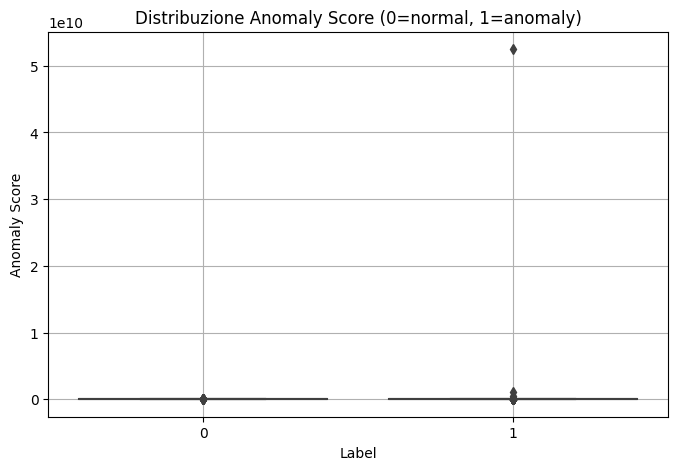

In [68]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

# Assicurati che il tuo modello sia in modalità eval
model.eval()

# Inference: calcolo recon, mu, logvar
with torch.no_grad():
    x_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    recon, mu, logvar = model(x_test_tensor)

# Calcolo reconstruction error (MSE per sample)
recon_error = torch.mean((x_test_tensor - recon) ** 2, dim=1)

# KL divergence per sample (sommata per dimensione)
logvar = torch.clamp(logvar, min=-10, max=10)  # sicurezza
kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)

# Anomaly score combinato (pesato)
alpha = 1.0  # peso per KL (puoi variare tra 0.1 e 1.0)
anomaly_score = recon_error + alpha * kl_div

# Calcolo AUC ROC
auc = roc_auc_score(y_test, anomaly_score.numpy())
print(f"✅ ROC AUC (recon + KL): {auc:.4f}")

# Boxplot della distribuzione score
df_scores = pd.DataFrame({
    'anomaly_score': anomaly_score.numpy(),
    'label': y_test.numpy()
})

plt.figure(figsize=(8, 5))
sns.boxplot(x="label", y="anomaly_score", data=df_scores)
plt.title("Distribuzione Anomaly Score (0=normal, 1=anomaly)")
plt.xlabel("Label")
plt.ylabel("Anomaly Score")
plt.grid(True)
plt.show()

## AUC-ROC VAE

In [70]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test, anomaly_score)
print(f"✅ VAE ROC AUC: {auc:.4f}")


✅ VAE ROC AUC: 0.3975


## Conv-VAE

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import KFold

# ───────────────────── Hyperparameters ─────────────────────
LATENT_DIMS   = [8, 16, 32]
BETAS         = [0.01, 0.1, 1.0]
BATCH_SIZE    = 32
LEARNING_RATE = 1e-3
EPOCHS        = 15
PATIENCE      = 5       # early stopping
N_FOLDS       = 5
SAMPLE_RATE   = 16000
N_MELS        = 64
DEVICE        = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 DEVICE: {DEVICE}")

# ───────────────────── Transforms ─────────────────────
mel_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE, n_mels=N_MELS)
db_transform  = torchaudio.transforms.AmplitudeToDB()

# ───────────────────── Dataset ─────────────────────
class MelDataset(Dataset):
    def __init__(self, root_dir):
        self.files = [os.path.join(root_dir, f)
                      for f in os.listdir(root_dir)
                      if f.lower().endswith('.wav')]
        if not self.files:
            raise FileNotFoundError(f"No .wav in {root_dir}")
    def __len__(self):
        return len(self.files)
    def __getitem__(self, idx):
        wav, sr = torchaudio.load(self.files[idx])
        if sr != SAMPLE_RATE:
            wav = torchaudio.functional.resample(
                wav, sr, SAMPLE_RATE)
        if wav.dim()>1:
            wav = wav.mean(dim=0, keepdim=True)
        spec = mel_transform(wav)
        spec = db_transform(spec)
        spec = (spec - spec.mean())/(spec.std()+1e-6)
        T = spec.size(-1)
        pad = (-T) % 8
        if pad:
            spec = F.pad(spec, (0,pad), mode='constant', value=0.)
        return spec  # [1, n_mels, T_padded]

# ───────────────────── Model ─────────────────────
class ConvVAE(nn.Module):
    def __init__(self, latent_dim, sample_shape):
        super().__init__()
        # encoder
        self.enc = nn.Sequential(
            nn.Conv2d(1, 16, 3, 2, 1), nn.ReLU(),
            nn.Conv2d(16,32, 3, 2, 1), nn.ReLU(),
            nn.Conv2d(32,64, 3, 2, 1), nn.ReLU()
        )
        # infer flatten size on CPU
        with torch.no_grad():
            cpu_dummy = torch.zeros(1,1,*sample_shape)
            C,H,W = self.enc(cpu_dummy).shape[1:]
        self.flatten_size = C*H*W

        # latent layers (created on CPU, poi .to(DEVICE))
        self.fc_mu     = nn.Linear(self.flatten_size, latent_dim)
        self.fc_logvar = nn.Linear(self.flatten_size, latent_dim)
        self.fc_dec    = nn.Linear(latent_dim, self.flatten_size)

        # decoder
        self.dec = nn.Sequential(
            nn.Unflatten(1,(C,H,W)),
            nn.ConvTranspose2d(C,32,3,2,1,1), nn.ReLU(),
            nn.ConvTranspose2d(32,16,3,2,1,1), nn.ReLU(),
            nn.ConvTranspose2d(16, 1,3,2,1,1), nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        return mu + torch.randn_like(std)*std

    def forward(self, x):
        if x.dim()==3:
            x = x.unsqueeze(1)      # [B,1,n_mels,T]
        h = self.enc(x)
        h_flat = h.view(x.size(0), -1)
        mu     = self.fc_mu(h_flat)
        logvar = self.fc_logvar(h_flat)
        z      = self.reparameterize(mu, logvar)
        dec_flat = self.fc_dec(z)
        recon    = self.dec(dec_flat)
        # crop temporal dim if serve
        if recon.size(-1) > x.size(-1):
            recon = recon[..., :x.size(-1)]
        return recon, mu, logvar

def vae_loss(recon, x, mu, logvar, beta):
    rec = F.mse_loss(recon, x, reduction='sum')
    kld = -0.5*torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return rec + beta*kld

# ───────────────────── Training per 1 fold ─────────────────────
def train_one(model, train_loader, val_loader, beta):
    model.to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    best_val, wait = float('inf'), 0

    for epoch in range(1, EPOCHS+1):
        # -- train --
        model.train()
        run_tr = 0.0
        for batch in train_loader:
            x = batch.to(DEVICE)
            recon, mu, logvar = model(x)
            loss = vae_loss(recon, x, mu, logvar, beta)
            optimizer.zero_grad(); loss.backward(); optimizer.step()
            run_tr += loss.item()
        avg_tr = run_tr / len(train_loader.dataset)

        # -- val --
        model.eval()
        run_vl = 0.0
        with torch.no_grad():
            for batch in val_loader:
                x = batch.to(DEVICE)
                recon, mu, logvar = model(x)
                run_vl += vae_loss(recon, x, mu, logvar, beta).item()
        avg_vl = run_vl / len(val_loader.dataset)

        print(f"      Epoch {epoch:02d} — tr_loss={avg_tr:.1f}, vl_loss={avg_vl:.1f}", flush=True)

        if avg_vl < best_val:
            best_val, wait = avg_vl, 0
        else:
            wait += 1
            if wait >= PATIENCE:
                print(f"        ↳ Early stopping @ epoca {epoch}", flush=True)
                break

    return best_val

# ───────────────────── Main CV Loop ─────────────────────
if __name__=='__main__':
    data_root  = '/kaggle/input'
    train_dir  = os.path.join(data_root,'dev_data','dev_data','slider','train')
    ds         = MelDataset(train_dir)
    shape      = ds[0].shape[1:]
    print(f"🎯 Train set: {len(ds)} esempi, shape={shape}")

    kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=42)
    best_score, best_cfg = float('inf'), None

    for ld in LATENT_DIMS:
        for b in BETAS:
            print(f"\n🔍 Provo latent_dim={ld}, beta={b}", flush=True)
            fold_vals = []
            for f,(tr_idx,vl_idx) in enumerate(kf.split(ds),1):
                print(f"  ▶ Fold {f}/{N_FOLDS}", flush=True)
                tr_ds = Subset(ds, tr_idx)
                vl_ds = Subset(ds, vl_idx)
                tr_ld = DataLoader(tr_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)
                vl_ld = DataLoader(vl_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
                model = ConvVAE(ld, shape)
                val_l = train_one(model, tr_ld, vl_ld, b)
                print(f"    → fold {f} val_loss = {val_l:.1f}", flush=True)
                fold_vals.append(val_l)

            avg_val = np.mean(fold_vals)
            print(f"  ▶ avg val_loss = {avg_val:.1f}", flush=True)
            if avg_val < best_score:
                best_score, best_cfg = avg_val, (ld,b)

    print(f"\n🏆 Best config: latent_dim={best_cfg[0]}, beta={best_cfg[1]} (CV loss={best_score:.1f})")


🚀 DEVICE: cuda
🎯 Train set: 2370 esempi, shape=torch.Size([64, 808])

🔍 Provo latent_dim=8, beta=0.01
  ▶ Fold 1/5
      Epoch 01 — tr_loss=46972.3, vl_loss=39666.5
      Epoch 02 — tr_loss=37808.4, vl_loss=36533.0
      Epoch 03 — tr_loss=36270.7, vl_loss=36044.5
      Epoch 04 — tr_loss=35891.9, vl_loss=35714.4
      Epoch 05 — tr_loss=35505.3, vl_loss=35335.0
      Epoch 06 — tr_loss=35078.3, vl_loss=34948.7
      Epoch 07 — tr_loss=34648.9, vl_loss=34533.0
      Epoch 08 — tr_loss=34376.2, vl_loss=34417.2
      Epoch 09 — tr_loss=34252.5, vl_loss=34288.9
      Epoch 10 — tr_loss=34164.6, vl_loss=34201.0
      Epoch 11 — tr_loss=34087.9, vl_loss=34140.9
      Epoch 12 — tr_loss=34036.1, vl_loss=34091.7
      Epoch 13 — tr_loss=33986.9, vl_loss=34080.1
      Epoch 14 — tr_loss=33948.6, vl_loss=34048.6
      Epoch 15 — tr_loss=33914.9, vl_loss=34040.1
    → fold 1 val_loss = 34040.1
  ▶ Fold 2/5
      Epoch 01 — tr_loss=48018.1, vl_loss=38502.4
      Epoch 02 — tr_loss=37451.7, vl_los

### Inference on test set and print ROC AUC, soglia and Accuracy with precision, recall and F1

In [8]:
import os
import torch
import torchaudio
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import (
    roc_auc_score, roc_curve,
    accuracy_score, precision_score,
    recall_score, f1_score
)

# 1) Hyperparametri fissi
LATENT_DIM  = 32
BETA        = 0.01
BATCH_SIZE  = 32
LR          = 1e-3
EPOCHS      = 50
PATIENCE    = 5
SAMPLE_RATE = 16000
N_MELS      = 64
DEVICE      = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", DEVICE)

# 2) Trasformazioni
mel_transform = torchaudio.transforms.MelSpectrogram(sample_rate=SAMPLE_RATE, n_mels=N_MELS)
db_transform  = torchaudio.transforms.AmplitudeToDB()

def preprocess(wav, sr):
    if sr != SAMPLE_RATE:
        wav = torchaudio.functional.resample(wav, sr, SAMPLE_RATE)
    if wav.dim()>1:
        wav = wav.mean(dim=0, keepdim=True)
    spec = mel_transform(wav)
    spec = db_transform(spec)
    spec = (spec - spec.mean())/(spec.std()+1e-6)
    T = spec.size(-1)
    pad = (-T) % 8
    if pad:
        spec = F.pad(spec, (0,pad), mode='constant', value=0.)
    return spec  # [1, n_mels, T_padded]

# 3) Dataset rapido per train e test
class QuickDS(Dataset):
    def __init__(self, wav_files):
        self.files = wav_files
    def __len__(self): return len(self.files)
    def __getitem__(self, i):
        wav, sr = torchaudio.load(self.files[i])
        return preprocess(wav, sr)

data_root  = '/kaggle/input/dev_data/dev_data/slider'
train_files = [os.path.join(data_root,'train',f) for f in os.listdir(os.path.join(data_root,'train')) if f.endswith('.wav')]
test_files  = [os.path.join(data_root,'test', f) for f in os.listdir(os.path.join(data_root,'test'))  if f.endswith('.wav')]

train_loader = DataLoader(QuickDS(train_files), batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)
test_loader  = test_files  # lo useremo file‐by‐file

# 4) Definizione ConvVAE e loss (copia esatta di prima)
class ConvVAE(torch.nn.Module):
    def __init__(self, latent_dim, sample_shape):
        super().__init__()
        self.enc = torch.nn.Sequential(
            torch.nn.Conv2d(1,16,3,2,1), torch.nn.ReLU(),
            torch.nn.Conv2d(16,32,3,2,1), torch.nn.ReLU(),
            torch.nn.Conv2d(32,64,3,2,1), torch.nn.ReLU()
        )
        # infer flatten size su CPU
        with torch.no_grad():
            dummy = torch.zeros(1,1,*sample_shape)
            C,H,W = self.enc(dummy).shape[1:]
        self.flatten_size = C*H*W
        self.fc_mu     = torch.nn.Linear(self.flatten_size, latent_dim)
        self.fc_logvar = torch.nn.Linear(self.flatten_size, latent_dim)
        self.fc_dec    = torch.nn.Linear(latent_dim, self.flatten_size)
        self.dec = torch.nn.Sequential(
            torch.nn.Unflatten(1,(C,H,W)),
            torch.nn.ConvTranspose2d(C,32,3,2,1,1), torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(32,16,3,2,1,1), torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(16,1,3,2,1,1), torch.nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        return mu + torch.randn_like(std)*std

    def forward(self, x):
        if x.dim()==3: x = x.unsqueeze(1)
        h = self.enc(x)
        h_flat = h.view(x.size(0), -1)
        mu     = self.fc_mu(h_flat)
        logvar = self.fc_logvar(h_flat)
        z      = self.reparameterize(mu, logvar)
        dec_flat = self.fc_dec(z)
        recon    = self.dec(dec_flat)
        if recon.size(-1) > x.size(-1):
            recon = recon[..., :x.size(-1)]
        return recon, mu, logvar

def vae_loss(recon, x, mu, logvar, beta):
    rec = F.mse_loss(recon, x, reduction='sum')
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return rec + beta*kld

# 5) Inferisco sample_shape dal primo batch di train
sample_shape = next(iter(train_loader))[0].shape[1:]  # (n_mels, T_padded)

# 6) Instanzia e retraina solo sul train set normale
model = ConvVAE(LATENT_DIM, sample_shape).to(DEVICE)
opt   = torch.optim.Adam(model.parameters(), lr=LR)

best_loss, wait = float('inf'), 0
print("\n🔄 Retraining finale (early-stopping patience=5):")
for ep in range(1, EPOCHS+1):
    model.train()
    tot = 0.0
    for batch in train_loader:
        x = batch.to(DEVICE)
        recon, mu, logvar = model(x)
        loss = vae_loss(recon, x, mu, logvar, BETA)
        opt.zero_grad(); loss.backward(); opt.step()
        tot += loss.item()
    avg = tot/len(train_loader.dataset)
    print(f"  Epoch {ep:02d}: train_loss = {avg:.1f}")
    if avg < best_loss:
        best_loss, wait = avg, 0
    else:
        wait += 1
        if wait>=PATIENCE:
            print(f"    ↳ Early stopping @ epoch {ep}\n")
            break

# 7) Salva subito il modello
torch.save(model.state_dict(), '/kaggle/working/best_conv_vae.pth')
print("✅ Model salvato in /kaggle/working/best_conv_vae.pth\n")

# 8) Inference sul test set e calcolo metriche
print("🧪 Inference sul test set…")
scores, labels = [], []
model.eval()
for fn in sorted(test_loader):
    wav, sr = torchaudio.load(fn)
    spec = preprocess(wav, sr).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        recon, mu, logvar = model(spec)
    mse = torch.mean((recon-spec)**2).item()
    scores.append(mse)
    labels.append(0 if 'normal' in os.path.basename(fn).lower() else 1)

auc  = roc_auc_score(labels, scores)
fpr, tpr, thr = roc_curve(labels, scores)
opt  = thr[(tpr-fpr).argmax()]
preds= [1 if s>opt else 0 for s in scores]

print(f"\n📊 Risultati finali:")
print(f"  ROC AUC    = {auc:.4f}")
print(f"  Threshold  = {opt:.4f}")
print(f"  Accuracy   = {accuracy_score(labels,preds):.4f}")
print(f"  Precision  = {precision_score(labels,preds):.4f}")
print(f"  Recall     = {recall_score(labels,preds):.4f}")
print(f"  F1-score   = {f1_score(labels,preds):.4f}")


Device: cuda

🔄 Retraining finale (early-stopping patience=5):
  Epoch 01: train_loss = 44562.1
  Epoch 02: train_loss = 40487.8
  Epoch 03: train_loss = 36501.5
  Epoch 04: train_loss = 35551.9
  Epoch 05: train_loss = 34846.1
  Epoch 06: train_loss = 34487.0
  Epoch 07: train_loss = 34229.1
  Epoch 08: train_loss = 33999.4
  Epoch 09: train_loss = 33857.3
  Epoch 10: train_loss = 33778.6
  Epoch 11: train_loss = 33706.4
  Epoch 12: train_loss = 33629.9
  Epoch 13: train_loss = 33580.8
  Epoch 14: train_loss = 33543.4
  Epoch 15: train_loss = 33521.2
  Epoch 16: train_loss = 33494.8
  Epoch 17: train_loss = 33447.0
  Epoch 18: train_loss = 33415.8
  Epoch 19: train_loss = 33386.7
  Epoch 20: train_loss = 33358.1
  Epoch 21: train_loss = 33334.5
  Epoch 22: train_loss = 33311.1
  Epoch 23: train_loss = 33288.7
  Epoch 24: train_loss = 33267.7
  Epoch 25: train_loss = 33254.9
  Epoch 26: train_loss = 33221.2
  Epoch 27: train_loss = 33189.8
  Epoch 28: train_loss = 33158.6
  Epoch 29: t